# Importation des packages 

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
## à compléter
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

import sklearn
from scipy.stats import mode # pour récupérer la médiane d'un varaible
from sklearn.preprocessing import MinMaxScaler, StandardScaler,MaxAbsScaler,RobustScaler# pour pouvoir faire scaling sur notre jeu des données 
from sklearn.model_selection import train_test_split # construction de la base de test et d'apprentissage
import pickle as pkl
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix,roc_curve,roc_auc_score
from sklearn.svm import SVR # séparation vaste Réfression : Support Vector Marge pour la régression
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dropout # régularization hyper-paramétre
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD # régularization hyper-paramétre ==> surveilleance de learning rate
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from statistics import mean
import seaborn as sb


Using TensorFlow backend.


On commence par faire un changement de répertoire current de travail

In [8]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


On passe au déclaration du chemin de mon répertoire

In [9]:
mypath ="drive/My Drive/la base des données_fraud_detection/" # chemin
!ls  "drive/My Drive/la base des données_fraud_detection/" # affichage des fichiers existants dans le répertoire

act_1-1.ipynb	       test_identity.csv     train_transaction.csv
act_1-2.ipynb	       test_transaction.csv
sample_submission.csv  train_identity.csv


 Importation du jeu de données 

In [0]:
test_identity = pd.read_csv(mypath+"test_identity.csv", sep = ',', header = 0,index_col = None,na_values=['NaN','nan']) # il y a le header=0
test_transaction = pd.read_csv(mypath+"test_transaction.csv", sep = ',', header = 0,index_col = None,na_values=['NaN','nan']) # il y a le header=0
train_transaction = pd.read_csv(mypath+"train_transaction.csv", sep = ',', header = 0,index_col = None,na_values=['NaN','nan']) # il y a le header=0 # transactions + varaibales cibles
train_identity = pd.read_csv(mypath+"train_identity.csv", sep = ',', header = 0,index_col = None,na_values=['NaN','nan']) # il y a le header=0 # caractéristique de chaque transaction
sample_submission = pd.read_csv(mypath+"sample_submission.csv", sep = ',', header = 0,index_col = None,na_values=['NaN','nan']) # il y a le header=0 # resultats finals 
test_identity= test_identity[1:20000]
test_transaction=test_transaction[1:20000]
train_transaction=train_transaction[1:20000]
train_identity=train_identity[1:20000]

Affichage des 5 premières lignes de notre jeu de données

In [11]:
train_transaction.head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2987005,0,86510,49.0,W,5937,555.0,150.0,visa,226.0,debit,272.0,87.0,36.0,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Affichage des 5 premières lignes de notre jeu de données

In [12]:
test_transaction.head(5)

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,299.0,87.0,4.0,NaN,aol.com,NaN,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,12.0,2.0,149.0,149.0,7.0,634.0,7.0,NaN,NaN,NaN,NaN,231.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,280.000000,77.000000,0.000000,280.000000,0.000000,77.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,472.0,87.0,2635.0,NaN,hotmail.com,NaN,2.0,2.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,2.0,0.0,22.0,2.0,137.0,137.0,10.0,97.0,10.0,NaN,NaN,NaN,NaN,136.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,1321.000000,0.000000,0.000000,1058.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,263.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,205.0,87.0,17.0,NaN,gmail.com,NaN,5.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,7.0,4.0,42.0,42.0,41.0,242.0,41.0,NaN,NaN,NaN,NaN,242.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,282.540009,282.540009,282.540009,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,264.0,87.0,6.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,2.0,5.0,0.0,0.0,5.0,0.0,6.0,0.0,14.0,6.0,22.0,22.0,0.0,22.0,0.0,NaN,NaN,NaN,NaN,22.0,...,0.0,0.0,0.0,0.0,0.0,1.0,67.949997,183.850006,67.949997,67.949997,183.850006,67.949997,67.949997,67.949997,183.850006,67.949997,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,3663554,18403323,57.95,W,12839,321.0,150.0,visa,226.0,debit,512.0,87.0,NaN,NaN,gmail.com,NaN,5.0,5.0,0.0,0.0,2.0,3.0,0.0,0.0,2.0,0.0,4.0,0.0,10.0,4.0,36.0,36.0,35.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,107.949997,107.949997,107.949997,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


train et test ne signifient pas les bases de test et de train, test signifie les transactions cibles pour prédire la variable y=isFraude donc ultérierement on aura besoin de split notre base train en deux :train_train et train_test, après avoir séparer les variables. Il nous faut aussi plus tard concaténer entre identity et transaction, puis faire extraire la variable cible et variables explicatives.


In [13]:
#la ligne d'en-tête n'est pas comptabilisée dans le nombre de lignes
print("la taille de train_transaction est : Nombre de lignes",train_transaction.shape[0]," et Nombre de colonnes",train_transaction.shape[1])
print("la taille de test_transaction est : Nombre de lignes",test_transaction.shape[0]," et Nombre de colonnes",test_transaction.shape[1])
print("la taille de train_identity est : Nombre de lignes",train_identity.shape[0]," et Nombre de colonnes :(varaibale cible non compris: à prédire)",train_identity.shape[1])
print("la taille de test_identity est : Nombre de lignes",test_identity.shape[0]," et Nombre de colonnes",test_identity.shape[1])
# il y a une différence au niveau de taille entre train_transaction et train identity cela aux personnes qui font plusieures fraudes ou bien on a des doublants dans notre Data.
print("la taille de submission est",sample_submission.shape[0],"\n et Nombre de colonnes",sample_submission.shape[1])


la taille de train_transaction est : Nombre de lignes 19999  et Nombre de colonnes 394
la taille de test_transaction est : Nombre de lignes 19999  et Nombre de colonnes 393
la taille de train_identity est : Nombre de lignes 19999  et Nombre de colonnes :(varaibale cible non compris: à prédire) 41
la taille de test_identity est : Nombre de lignes 19999  et Nombre de colonnes 41
la taille de submission est 506691 
 et Nombre de colonnes 2


In [14]:
# types des varaibles 
print("le type des varaibles de  transaction est : \n",train_transaction.dtypes)
print("\nle type des varaibles d'identity est :\n ",train_identity.dtypes)

le type des varaibles de  transaction est : 
 TransactionID       int64
isFraud             int64
TransactionDT       int64
TransactionAmt    float64
ProductCD          object
                   ...   
V335              float64
V336              float64
V337              float64
V338              float64
V339              float64
Length: 394, dtype: object

le type des varaibles d'identity est :
  TransactionID      int64
id_01            float64
id_02            float64
id_03            float64
id_04            float64
id_05            float64
id_06            float64
id_07            float64
id_08            float64
id_09            float64
id_10            float64
id_11            float64
id_12             object
id_13            float64
id_14            float64
id_15             object
id_16             object
id_17            float64
id_18            float64
id_19            float64
id_20            float64
id_21            float64
id_22            float64
id_23             object

In [15]:
#description des données : pour avoir des idées sur la structure et détecter les failles de notre jeu de données
print(train_transaction.describe(include='all'))

        TransactionID       isFraud  ...         V338         V339
count    1.999900e+04  19999.000000  ...  3371.000000  3371.000000
unique            NaN           NaN  ...          NaN          NaN
top               NaN           NaN  ...          NaN          NaN
freq              NaN           NaN  ...          NaN          NaN
mean     2.997000e+06      0.028101  ...    15.874221    12.413230
std      5.773358e+03      0.165267  ...   104.531092    78.130309
min      2.987001e+06      0.000000  ...     0.000000     0.000000
25%      2.992000e+06      0.000000  ...     0.000000     0.000000
50%      2.997000e+06      0.000000  ...     0.000000     0.000000
75%      3.002000e+06      0.000000  ...     0.000000     0.000000
max      3.006999e+06      1.000000  ...  1630.000000  1500.000000

[11 rows x 394 columns]


Description des données pour avoir des idées sur la structure et détecter des failles de notre jeu de données.

In [16]:
print(train_identity.describe(include='all'))

        TransactionID         id_01          id_02  ...  id_38  DeviceType  DeviceInfo
count    1.999900e+04  19999.000000   19534.000000  ...  19534       19530       17552
unique            NaN           NaN            NaN  ...      2           2         638
top               NaN           NaN            NaN  ...      T     desktop     Windows
freq              NaN           NaN            NaN  ...  16070       13243        7518
mean     3.019894e+06     -8.087804  132269.395260  ...    NaN         NaN         NaN
std      1.603023e+04     13.805693  120971.925195  ...    NaN         NaN         NaN
min      2.987008e+06   -100.000000    1120.000000  ...    NaN         NaN         NaN
25%      3.007368e+06     -5.000000   53235.250000  ...    NaN         NaN         NaN
50%      3.021393e+06     -5.000000   97771.500000  ...    NaN         NaN         NaN
75%      3.033500e+06     -5.000000  169048.250000  ...    NaN         NaN         NaN
max      3.045231e+06      0.000000  998295

# Traitement des valeurs manquantes et doublantes :

## Concaténation des bases des données :

In [17]:
test = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True) # ID de transaction y compris
train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True) # ID de transaction y compris, Y exclue
print("taille de la base test", test.shape)
print("taille de la base train", train.shape)
train.drop(['TransactionID_x'],axis=1)
test.drop(['TransactionID_x'],axis=1)


taille de la base test (19999, 434)
taille de la base train (19999, 435)


,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,...,id-01,id-02,id-03,id-04,id-05,id-06,id-07,id-08,id-09,id-10,id-11,id-12,id-13,id-14,id-15,id-16,id-17,id-18,id-19,id-20,id-21,id-22,id-23,id-24,id-25,id-26,id-27,id-28,id-29,id-30,id-31,id-32,id-33,id-34,id-35,id-36,id-37,id-38,DeviceType,DeviceInfo
1,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,299.0,87.0,4.0,NaN,aol.com,NaN,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,12.0,2.0,149.0,149.0,7.0,634.0,7.0,NaN,NaN,NaN,NaN,231.0,634.0,...,0.0,3579.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,Found,NaN,-300.0,Found,Found,166.0,NaN,542.0,368.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Android 6.0.1,chrome 67.0 for android,24.0,1280x720,match_status:2,T,F,T,T,mobile,LGLS676 Build/MXB48T
2,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,472.0,87.0,2635.0,NaN,hotmail.com,NaN,2.0,2.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,2.0,0.0,22.0,2.0,137.0,137.0,10.0,97.0,10.0,NaN,NaN,NaN,NaN,136.0,136.0,...,-5.0,185210.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,-360.0,New,NotFound,225.0,NaN,271.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,ie 11.0 for tablet,NaN,NaN,NaN,F,T,T,F,desktop,Trident/7.0
3,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,205.0,87.0,17.0,NaN,gmail.com,NaN,5.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,7.0,4.0,42.0,42.0,41.0,242.0,41.0,NaN,NaN,NaN,NaN,242.0,242.0,...,-45.0,252944.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,27.0,NaN,Found,Found,225.0,15.0,427.0,563.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
4,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,264.0,87.0,6.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,2.0,5.0,0.0,0.0,5.0,0.0,6.0,0.0,14.0,6.0,22.0,22.0,0.0,22.0,0.0,NaN,NaN,NaN,NaN,22.0,22.0,...,-95.0,328680.0,NaN,NaN,7.0,-33.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,NaN,New,NotFound,225.0,15.0,567.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,SM-G9650 Build/R16NW
5,18403323,57.95,W,12839,321.0,150.0,visa,226.0,debit,512.0,87.0,NaN,NaN,gmail.com,NaN,5.0,5.0,0.0,0.0,2.0,3.0,0.0,0.0,2.0,0.0,4.0,0.0,10.0,4.0,36.0,36.0,35.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,...,-5.0,36786.0,NaN,NaN,4.0,-2.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,-480.0,New,NotFound,166.0,15.0,352.0,177.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.4.0,mobile safari 11.0,32.0,2208x1242,match_status:2,T,F,F,T,mobile,iOS Device
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,19076952,59.00,W,12695,490.0,150.0,visa,226.0,debit,325.0,87.0,NaN,NaN,yahoo.com,NaN,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,1.0,561.0,561.0,357.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,...,0.0,3547.0,0.0,0.0,2.0,-5.0,NaN,NaN,0.0,0.0,100.0,Found,NaN,-300.0,Found,Found,166.0,17.0,352.0,277.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Linux,chrome 68.0,24.0,2560x1440,match_status:2,T,F,T,T,desktop,NaN
19996,19076953,125.00,R,11520,399.0,150.0,american express,118.0,credit,204.0,87.0,NaN,NaN,gmail.com,yahoo.com,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-20.0,305825.0,NaN,NaN,-9.0,-26.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,NaN,New,NotFound,225.0,15.0,266.0,563.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 68.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,SM-J701M Build/NRD90M
19997,19077019,35.95,W,10313,258.0,150.0,visa,226.0,debit,469.0,87.0,11.0,NaN,gmail.com,NaN,4.0,4.0,0.0,0.0,1.0,3.0,0.0,0.0,2.0,0.0,3.0,0.0,18.0,4.0,83.0,83.0,7.0,84.0,7.0,NaN,NaN,NaN,NaN,84.0,100.0,.

## Data Visualisation ==> Target

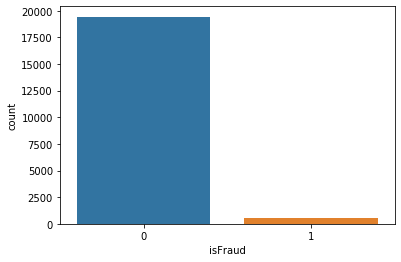

From total data  2.81 % contains fraud train
From total data  97.19 % contains legit train


In [18]:
import seaborn as sns
sns.countplot(train['isFraud'])
plt.show()
print('From total data ',np.round(train[train['isFraud']==1].shape[0]/train.shape[0]*100,2),'% contains fraud train')
print('From total data ',np.round(train[train['isFraud']==0].shape[0]/train.shape[0]*100,2),'% contains legit train')


In [0]:
del train['TransactionID_x']
del test['TransactionID_x']
del train['TransactionID_y']
del test['TransactionID_y']

## Réduction de mémoire 

In [0]:
from tqdm import tqdm
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in tqdm(df.columns):
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [21]:
 # à supprimer dans le cas d'apparition d'erreur  de genre :  ValueError: Shape of passed values is blah, indices imply blah2
train=reduce_mem_usage(train)
test=reduce_mem_usage(test)
print('training set shape:', train.shape)
print('test set shape:', test.shape)

  3%|▎         | 11/432 [00:00<00:04, 96.33it/s]

Mem. usage decreased to 20.20 Mb (69.4% reduction)


100%|██████████| 432/432 [00:04<00:00, 101.61it/s]

Mem. usage decreased to 20.14 Mb (69.4% reduction)
training set shape: (19999, 433)
test set shape: (19999, 432)


Supression des clients qui ont NAN comme valeur de varaiable cible ensuite traitements des valeurs manquantes standards et non standards et calcule du nombre total de valeurs manquantes pour chaque caractéristique.


In [22]:
# valeurs manquentes par colonne : par varaible
print("\n nombre totale de valeurs manquentes pour ISFraude ",train['isFraud'].isnull().sum() ) # filtrage nombre de valeurs manquantes pour la variable cible


 nombre totale de valeurs manquentes pour ISFraude  0


In [23]:
# supprision des doublants ###########################################base train

dupli_train=train.duplicated() # récupération de vecteur des valeurs de la fonction duplicate
# on affiche les lignes doublontes par 
print(train[train.duplicated()])
print(" le nombre des valeurs doublons  est : ", train[train.duplicated()].shape)
# Révérification 
############### méthode 1
print(" le nombre des valeurs doublontes aprés le traitement  est : ", len(dupli_train[dupli_train.values==True]))

Empty DataFrame
Columns: [isFraud, TransactionDT, TransactionAmt, ProductCD, card1, card2, card3, card4, card5, card6, addr1, addr2, dist1, dist2, P_emaildomain, R_emaildomain, C1, C2, C3, C4, C5, C6, C7, C8, C9, C10, C11, C12, C13, C14, D1, D2, D3, D4, D5, D6, D7, D8, D9, D10, D11, D12, D13, D14, D15, M1, M2, M3, M4, M5, M6, M7, M8, M9, V1, V2, V3, V4, V5, V6, V7, V8, V9, V10, V11, V12, V13, V14, V15, V16, V17, V18, V19, V20, V21, V22, V23, V24, V25, V26, V27, V28, V29, V30, V31, V32, V33, V34, V35, V36, V37, V38, V39, V40, V41, V42, V43, V44, V45, V46, ...]
Index: []

[0 rows x 433 columns]
 le nombre des valeurs doublons  est :  (0, 433)
 le nombre des valeurs doublontes aprés le traitement  est :  0


## Suppresion des doublants {base test}

In [24]:
dupli_test=test.duplicated() # récupération des valeurs des vecteurs de la fonction duplicate
# on affiche les lignes doublonts par: 
print(test[test.duplicated()])
print(" le nombre des valeurs doublons  est : ", test[test.duplicated()].shape)
# Révérification 
    # méthode 1
print(" le nombre des valeurs doublontes aprés le traitement  est : ", len(dupli_test[dupli_test.values==True]))



Empty DataFrame
Columns: [TransactionDT, TransactionAmt, ProductCD, card1, card2, card3, card4, card5, card6, addr1, addr2, dist1, dist2, P_emaildomain, R_emaildomain, C1, C2, C3, C4, C5, C6, C7, C8, C9, C10, C11, C12, C13, C14, D1, D2, D3, D4, D5, D6, D7, D8, D9, D10, D11, D12, D13, D14, D15, M1, M2, M3, M4, M5, M6, M7, M8, M9, V1, V2, V3, V4, V5, V6, V7, V8, V9, V10, V11, V12, V13, V14, V15, V16, V17, V18, V19, V20, V21, V22, V23, V24, V25, V26, V27, V28, V29, V30, V31, V32, V33, V34, V35, V36, V37, V38, V39, V40, V41, V42, V43, V44, V45, V46, V47, ...]
Index: []

[0 rows x 432 columns]
 le nombre des valeurs doublons  est :  (0, 432)
 le nombre des valeurs doublontes aprés le traitement  est :  0


In [25]:
# Valeur manquante  par colonnes 
[print(" nombre totale de valeurs manquentes pour Train ",i, "est :",train[i].isnull().sum() ) for i in train.columns if train[i].isnull().sum()!=0] # filtrage
[print(" nombre totale de valeurs manquentes pour Test ",i, "est :",test[i].isnull().sum() ) for i in test.columns if test[i].isnull().sum()!=0] # filtrage



 nombre totale de valeurs manquentes pour Train  card2 est : 243
 nombre totale de valeurs manquentes pour Train  card3 est : 1
 nombre totale de valeurs manquentes pour Train  card4 est : 3
 nombre totale de valeurs manquentes pour Train  card5 est : 73
 nombre totale de valeurs manquentes pour Train  card6 est : 1
 nombre totale de valeurs manquentes pour Train  addr1 est : 1676
 nombre totale de valeurs manquentes pour Train  addr2 est : 1676
 nombre totale de valeurs manquentes pour Train  dist1 est : 13168
 nombre totale de valeurs manquentes pour Train  dist2 est : 19045
 nombre totale de valeurs manquentes pour Train  P_emaildomain est : 4180
 nombre totale de valeurs manquentes pour Train  R_emaildomain est : 16502
 nombre totale de valeurs manquentes pour Train  D2 est : 9443
 nombre totale de valeurs manquentes pour Train  D3 est : 8866
 nombre totale de valeurs manquentes pour Train  D4 est : 11126
 nombre totale de valeurs manquentes pour Train  D5 est : 13680
 nombre total

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [26]:
#Méthode manuelle : valeurs manquantes par ligne
def num_missing(x):
    return sum(x.isnull())
# Application pour chaque ligne:

print("\nValeurs manquantes Train  par ligne:")
print(train.apply(num_missing, axis=1))

print("\nValeurs manquantes Test par ligne:")
print(test.apply(num_missing, axis=1))


Valeurs manquantes Train  par ligne:
1        204
2        186
3        207
4        130
5        183
        ... 
19995     86
19996    190
19997    182
19998    208
19999    131
Length: 19999, dtype: int64

Valeurs manquantes Test par ligne:
1        183
2        186
3        187
4        188
5        185
        ... 
19995    184
19996    137
19997    182
19998    127
19999    177
Length: 19999, dtype: int64


## Attention:
On va renomer nos variables id_Med

In [0]:
test.rename(columns=lambda x: x.replace("-","_"), inplace=True)


In [28]:
(train.columns).shape[0]-(test.columns).shape[0]

1

Suppression des colonnes qui ont plus de 90% des valeurs manquantes:

In [0]:
def dro_p(base,base1,pourc):
  for i in base.columns :
    if base[i].isnull().sum() >= base.shape[0]*pourc:
      if i in base1.columns:
        base1.drop([i], axis='columns', inplace=True)
        base.drop([i], axis='columns', inplace=True)

dro_p(train,test,0.9) # appelle de la fonction qui supprimer les colonnes correspondants un nombre des valeurs manquantes supérieur que 1/3 de la taille de notre jeu de données
# on doit suprimer les colonnes de la base test et train , sinon il y'aura des problémes au niveau de la prédiction

In [30]:
(train.columns).shape[0]-(test.columns).shape[0]

1

##Taux des valeurs manquantes pour chaque varaible train

In [31]:
# pourcentage des données nulles pour chaque varaible
data_null_train = train.isnull().sum()/len(train) * 100
data_null_train = data_null_train.drop(data_null_train[data_null_train == 0].index).sort_values(ascending=False)[:500]
missing_data_train = pd.DataFrame({'Missing Ratio_train ': data_null_train})
missing_data_train.head()

,Missing Ratio_train
D9,86.959348
D8,86.959348
V164,83.209160
V157,83.209160
V153,83.209160


##Taux des valeurs manquantes pour chaque varaible test

In [52]:
data_null_test = test.isnull().sum()/len(test) * 100
data_null_test = data_null_test.drop(data_null_test[data_null_test == 0].index).sort_values(ascending=False)[:500]
missing_data_test = pd.DataFrame({'Missing Ratio_train ': data_null_test})
missing_data_test.head()

,Missing Ratio_train
V150,92.574629
V153,92.574629
V138,92.574629
V139,92.574629
V140,92.574629


Text(0, 0.5, 'Missing rate_train')

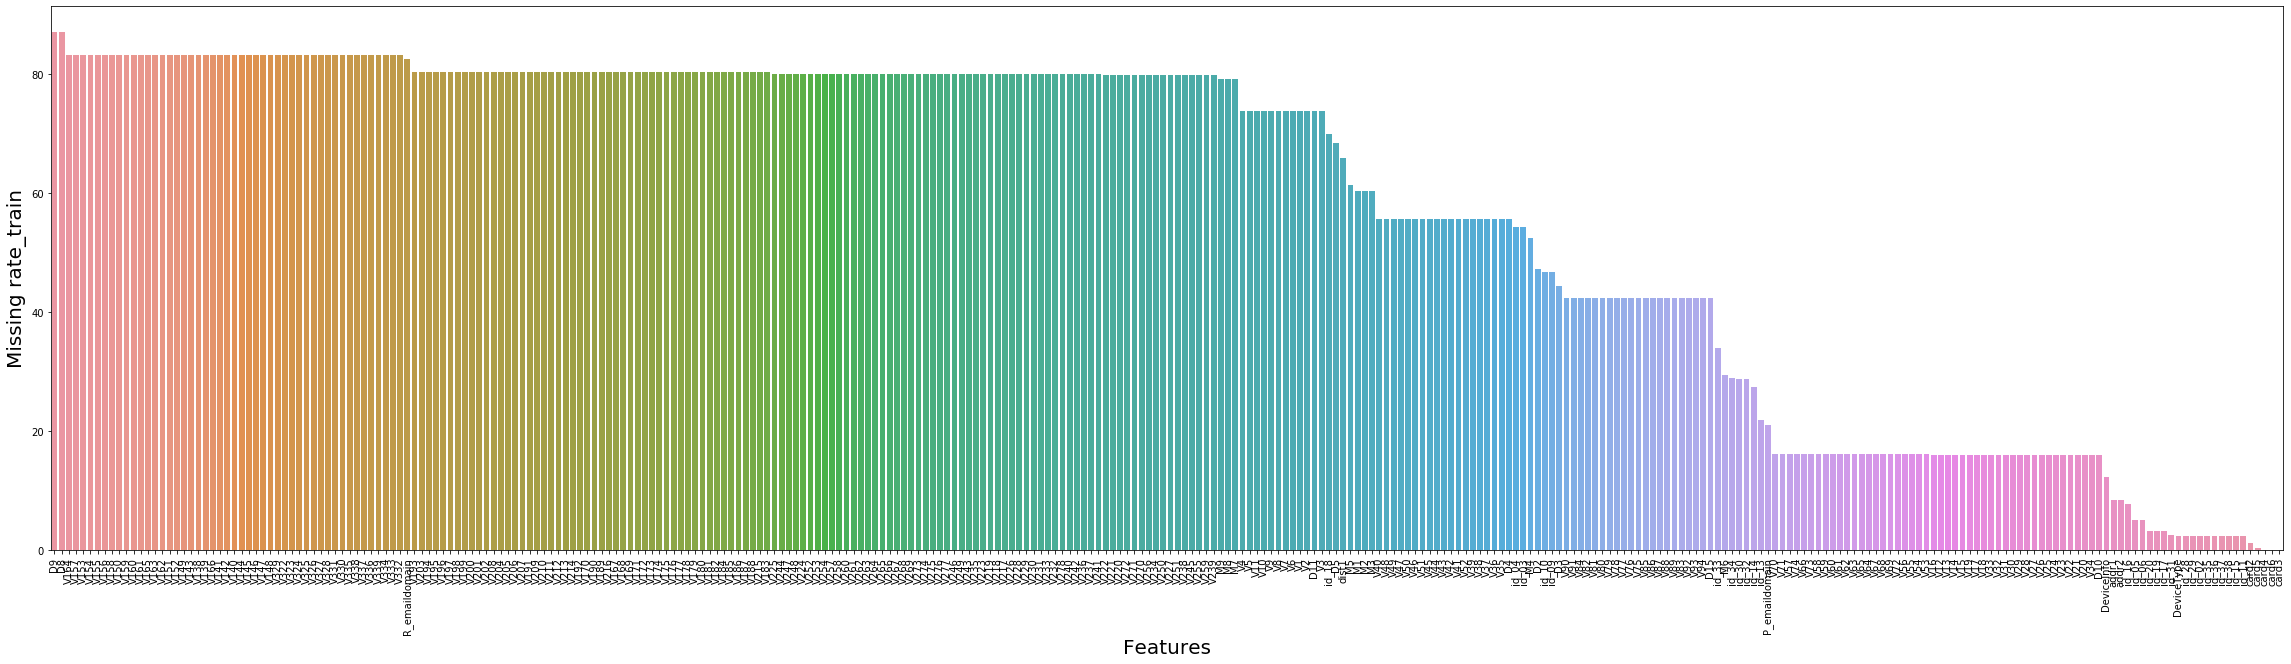

In [53]:

import seaborn as sns

plt.subplots(figsize=(40,10))
plt.xticks(rotation='90')
sns.barplot(data_null_train.index, data_null_train)
plt.xlabel('Features', fontsize=20)
plt.ylabel('Missing rate_train', fontsize=20)

Text(0, 0.5, 'Missing rate_test')

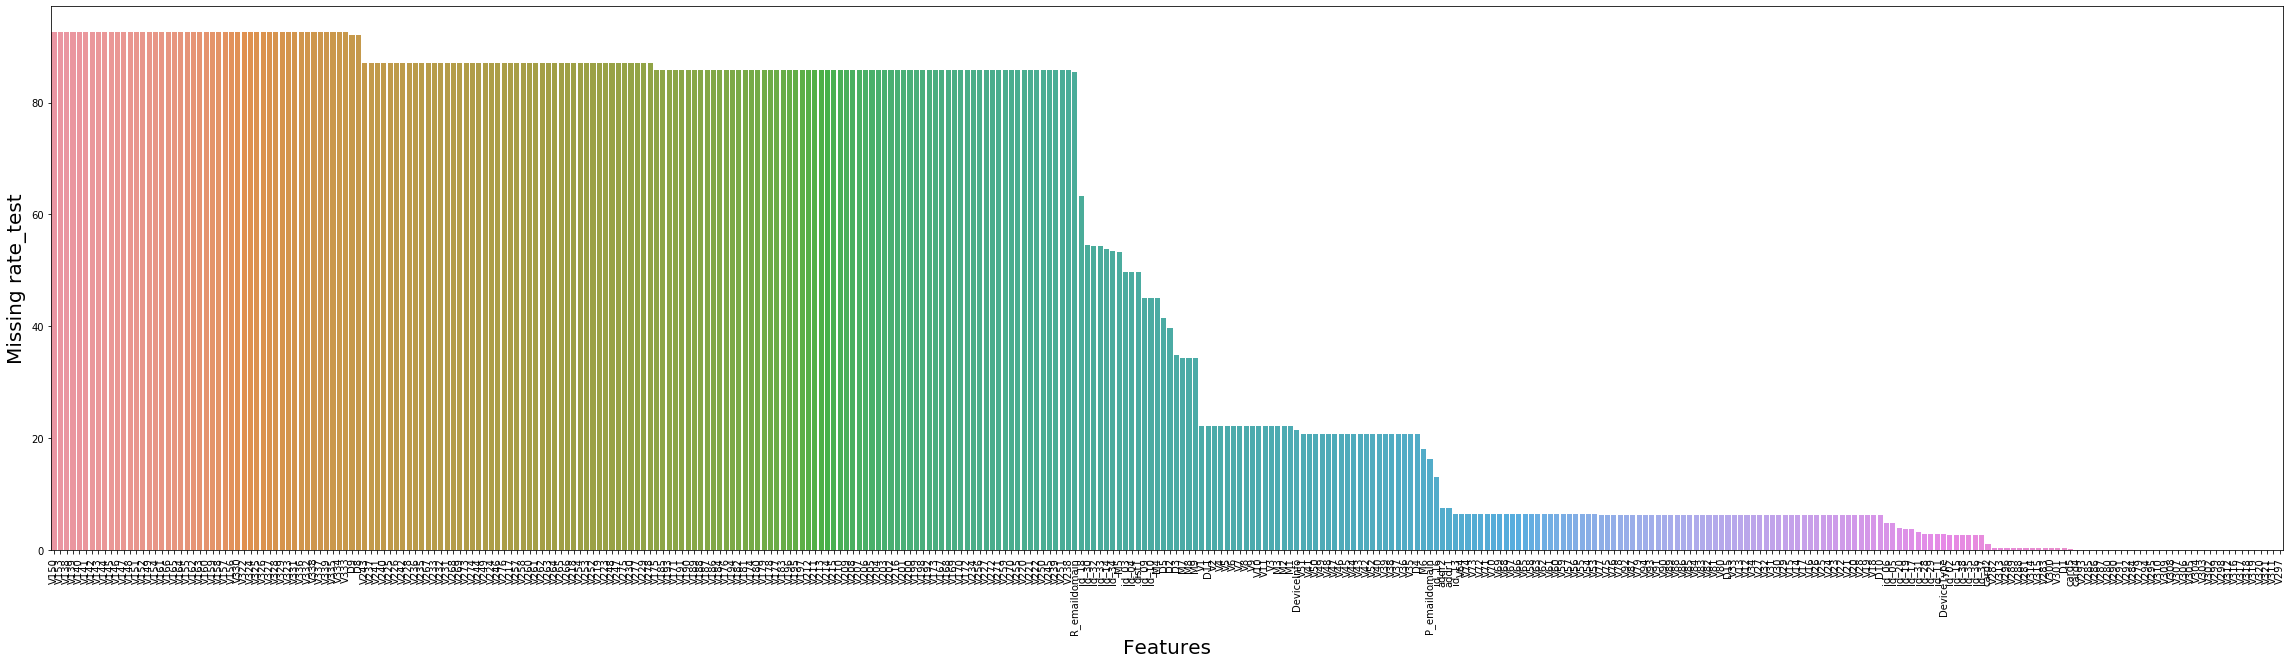

In [54]:
import seaborn as sns

plt.subplots(figsize=(40,10))
plt.xticks(rotation='90')
sns.barplot(data_null_test.index, data_null_test)
plt.xlabel('Features', fontsize=20)
plt.ylabel('Missing rate_test', fontsize=20)

## imputation des valeurs manquantes 
Maintenant, nous allonsremplir les valeurs manquantes en utilisant la technique du mode mais il faut faire attention au varaible qualitative qui sont inimputable par la moyenne.


In [55]:
def Imput(base) :
  base1=pd.DataFrame()
  base1=base.copy()
  for i in base.columns:
    if base[i].dtypes!= object:
        t =pd.DataFrame()
        t=base1[i].copy() # pour calculer la moyenne np.nanmean retourne inf et np.mean n'est pas valble dans le cas ou il ya des nan , donc on a procédeé par écarter de nanpourque on puisse calcler mean
            #np.nanmean(t.dropna(inplace=True))
        t.dropna(inplace=True)
        base1[i].fillna(np.mean(np.array(t)),inplace=True)
    if base[i].dtypes=='object':
      base1[i].fillna(base1[i].mode().iloc[0],inplace=True)
  return base1

train_mode_mean=Imput(train)
test_mode_mean=Imput(test)

# re-teste les valeurs manquantes de nouveau pour valider par deux méthodes 
[print(" nombre totale de valeurs manquentes pour train ",i, "est :",train_mode_mean[i].isnull().sum() ) for i in train_mode_mean.columns if train_mode_mean[i].isnull().sum()!=0] # filtrage
# il y a plus des valeurs manquantes dans notre jeu de données
[print(" nombre totale de valeurs manquentes pour test ",i, "est :",test_mode_mean[i].isnull().sum() ) for i in test_mode_mean.columns if test_mode_mean[i].isnull().sum()!=0] # filtrage
print(train_mode_mean.shape)
print(test_mode_mean.shape)

(19999, 418)
(19999, 417)


In [56]:

variabel_quantitative=[i for i in train.columns if train[i].dtypes=='int64' or train[i].dtypes=='float64']
variabel_qualitative=[i for i in train.columns if train[i].dtypes=='object']
print("taille des varaibles qualitative",len(variabel_qualitative))
print("taille des varaibles qauntitative",len(variabel_quantitative))

taille des varaibles qualitative 29
taille des varaibles qauntitative 0


I was able to impute the categorical variables using the steps listed below. I will gladly welcome any omissions or program that can perform such tasks automatically

Step1: Subsets the object's data types(all) into another container

Step2: Change np.NaN into an object data type, say None. Now, the container is made up of only objects data types

Step3: Change the entire container into categorical datasets

Step4: Encode the data set(i am using .cat.codes)

Step5: Change back the value of encoded None into np.NaN

Step5: Use KNN (from fancyimpute) to impute the missing values

Step6: Re-map the encoded dataset to its initial names

In [57]:
# Il est préférable d'utiliser LabelEncoder que ordinal encoder, LE: operations réversible: 0--> 'a' et 'a'-->0
from sklearn.preprocessing import LabelEncoder
##
train_enco=pd.DataFrame()
test_enco=pd.DataFrame()
###
for i in train.columns:
  train_enco[i]= train[i].copy()
###   
for j in test.columns:
  test_enco[j]= test[j].copy()
####
for col in variabel_qualitative:
    if col in train_enco.columns :
        le = LabelEncoder()
        le.fit(list(train_enco[col].astype(str).values) + list(test_enco[col].astype(str).values))
        train_enco[col] = le.transform(list(train_enco[col].astype(str).values)) # pour décodage train_enco[col]=le.inverse_transform(train_enco[col])
        test_enco[col] = le.transform(list(test_enco[col].astype(str).values))  # opération inverse train_enco[col]=le.inverse_transform(train_enco[col])
        # pour encodeur labelEncode ne différencie par entre nan ) numpy et nan=valeure ou objet
        # on va remplacer les nan coder par les nan
        if 'nan' in list((LabelEncoder().fit(list(test[col].astype(str).values))).classes_):
           test_enco[col][test_enco[col]==list(le.classes_).index('nan')]=np.nan
        if 'nan' in list((LabelEncoder().fit(list(train[col].astype(str).values))).classes_):
           train_enco[col][train_enco[col]==list(le.classes_).index('nan')]=np.nan


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [58]:
list((LabelEncoder().fit(list(test_enco['card4'].astype(str).values))).classes_)# list(.classes_)

['0.0', '1.0', '2.0', '4.0', 'nan']

Standardidation et normalisation des varaibles continues afin d'appliquer knn sur la base de données (train et test)_enco. Il faut faire scaling manuel.

In [0]:
# fonction scaling et inverse 
def scaling_min_max(base,minn,maxx, varaible_continue):
  base1=base.copy()
  for i in varaible_continue:
    base1[i]=(base1[i]-minn[i])/(maxx[i]-minn[i]).astype(base[i].dtypes)
  return base1
def descaling_min_max(base_scaled,minn,maxx, varaible_continue):
  base1=base_scaled.copy()
  for i in varaible_continue:
    base1[i]=(((base1[i])*(maxx[i]-minn[i]))+minn[i]).astype(base_scaled[i].dtypes)
  return base1

In [0]:
#scaling 
v=variabel_quantitative[1:len(variabel_quantitative)] # is fraud est catégorielle mais il est déclarer comme varaible continue
Min_train=train_enco[v].min()
Max_train=train_enco[v].max()
Min_test=test_enco[v].min()
Max_test=test_enco[v].max()
#Min_test['id_32'] # accées aux valeures 



In [61]:
scaling_min_max(train_enco,Min_train,Max_train,v)
scaling_min_max(test_enco,Min_test,Max_test,v)

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D8,D9,D10,D11,D15,M1,M2,...,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
1,18403263,49.0000,4,4272,111.0,150.0,4.0,226.0,1,299.0,87.0,4.0,2.0,NaN,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,12.0,2.0,149.0,149.0,7.0,634.0,7.0,NaN,NaN,231.0,634.0,634.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,3579.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0,NaN,-300.0,0.0,0.0,166.0,NaN,542.0,368.0,0.0,0.0,6.0,52.0,24.0,23.0,3.0,1.0,0.0,1.0,1.0,1.0,370.0
2,18403310,171.0000,4,4476,574.0,150.0,4.0,226.0,1,472.0,87.0,2636.0,19.0,NaN,2.0,2.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,2.0,0.0,22.0,2.0,137.0,137.0,10.0,97.0,10.0,NaN,NaN,136.0,136.0,97.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.0,185210.0,NaN,NaN,1.0,0.0,NaN,NaN,100.0,1,52.0,-360.0,1.0,1.0,225.0,NaN,271.0,507.0,1.0,1.0,NaN,90.0,NaN,NaN,NaN,0.0,1.0,1.0,0.0,0.0,1012.0
3,18403310,285.0000,4,10989,360.0,150.0,4.0,166.0,1,205.0,87.0,17.0,16.0,NaN,5.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,7.0,4.0,42.0,42.0,41.0,242.0,41.0,NaN,NaN,242.0,242.0,242.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-45.0,252944.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,1,27.0,NaN,0.0,0.0,225.0,15.0,427.0,563.0,0.0,0.0,NaN,52.0,NaN,NaN,NaN,0.0,0.0,1.0,0.0,1.0,425.0
4,18403317,67.9375,4,18018,452.0,150.0,2.0,117.0,1,264.0,87.0,6.0,16.0,NaN,6.0,6.0,0.0,0.0,2.0,5.0,0.0,0.0,5.0,0.0,6.0,0.0,14.0,6.0,22.0,22.0,0.0,22.0,0.0,NaN,NaN,22.0,22.0,22.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-95.0,328680.0,NaN,NaN,7.0,-33.0,NaN,NaN,100.0,1,27.0,NaN,1.0,1.0,225.0,15.0,567.0,507.0,1.0,1.0,NaN,52.0,NaN,NaN,NaN,0.0,0.0,1.0,0.0,1.0,861.0
5,18403323,57.9375,4,12839,321.0,150.0,4.0,226.0,1,512.0,87.0,NaN,16.0,NaN,5.0,5.0,0.0,0.0,2.0,3.0,0.0,0.0,2.0,0.0,4.0,0.0,10.0,4.0,36.0,36.0,35.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.0,36786.0,NaN,NaN,4.0,-2.0,NaN,NaN,100.0,1,27.0,-480.0,1.0,1.0,166.0,15.0,352.0,177.0,1.0,1.0,74.0,93.0,32.0,110.0,3.0,1.0,0.0,0.0,1.0,1.0,1111.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,19076952,59.0000,4,12695,490.0,150.0,4.0,226.0,1,325.0,87.0,NaN,54.0,NaN,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,1.0,561.0,561.0,357.0,0.0,NaN,NaN,NaN,0.0,0.0,561.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,3547.0,0.0,0.0,2.0,-5.0,0.0,0.0,100.0,0,NaN,-300.0,0.0,0.0,166.0,17.0,352.0,277.0,0.0,0.0,13.0,54.0,24.0,128.0,3.0,1.0,0.0,1.0,1.0,0.0,NaN
19996,19076953,125.0000,2,11520,399.0,150.0,0.0,118.0,0,204.0,87.0,NaN,16.0,49.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-20.0,305825.0,NaN,NaN,-9.0,-26.0,NaN,NaN,100.0,1,27.0,NaN,1.0,1.0,225.0,15.0,266.0,563.0,1.0,1.0,NaN,55.0,NaN,NaN,NaN,0.0,0.0,1.0,0.0,1.0,905.0
19997,19077019,35.9375,4,10313,258.0,150.0,4.0,226.0,1,469.0,87.0,11.0,16.0,NaN,4.0,4.0,0.0,0.0,1.0,3.0,0.0,0.0,2.0,0.0,3.0,0.0,18.0,4.0,83.0,83.0,7.0,84.0,7.0,NaN,NaN,84.0,100.0,84.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.0,86359.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,1,27.0,-300.0,0.0,0.0,166.0,15.0,542.0,600.0,0.0,0.0,37.0,109.0,24.0,142.0,3.0,1.0,0.0,1.0,0.0,0.0,427.0
19998,19077032,50.0000,2,5629,490.0,150.0,4.0,226.0,1,126.0,87.0,NaN,23.0,15.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,8.789062,0.791504,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [62]:
variabel_quantitative_enco=[i for i in train_enco.columns if train_enco[i].dtypes=='int64' or train_enco[i].dtypes=='float64']
variabel_qualitative_enco=[i for i in train_enco.columns if train_enco[i].dtypes=='object']
print("taille des varaibles qualitative apres encoding",len(variabel_qualitative_enco)) # forcement égale 0
print("taille des varaibles qauntitative apres encoding",len(variabel_quantitative_enco)) # forcement égale len(train_enco.columns)


taille des varaibles qualitative apres encoding 0
taille des varaibles qauntitative apres encoding 29


## Imputaion par KNN :
 D'abord la coversion de data frame à une list avec train.values.tolist(), au data frame avec pandas.DataFramen. Scaling est obligatoire pour faire KNN.

In [0]:
#Catégorical

from sklearn.impute import KNNImputer  # pour varaible continue

def knn_impute(base,nobmer_neighbors):
  imputer = KNNImputer(n_neighbors=nobmer_neighbors)
  return  pd.DataFrame((imputer.fit_transform(base.values.tolist())),columns=base.columns)



In [0]:
train_knn=knn_impute(train_enco[1:123],3) #.merge(pd.DataFrame(train[variabel_quali]), how='left', left_index=True, right_index=True) 
test_knn=knn_impute(test_enco[1:123],3)

In [77]:
train_knn[1:10]

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D8,D9,D10,D11,D15,M1,...,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
1,0.0,86499.0,50.000,4.0,18132.0,567.0,150.0,2.0,117.0,1.0,476.000000,87.0,2.666667,54.0,17.000000,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.000000,0.000000,94.000000,0.000000,72.000000,0.0,84.000000,213.666667,111.000000,0.0,...,33.333333,80.000000,46.666667,0.0,46.666667,13.333333,0.0,0.0,0.0,-5.0,221832.0,0.000000,0.0,0.000000,-6.000000,0.000000,0.0,100.0,1.0,52.000000,-340.0,1.000000,1.000000,225.0,16.000000,176.0,507.000000,1.000000,1.000000,26.666667,36.0,32.000000,108.000000,3.000000,0.0,0.0,1.0,1.0,0.000000,668.333333
2,0.0,86506.0,50.000,1.0,4497.0,514.0,150.0,2.0,102.0,0.0,420.000000,87.0,9.333333,16.0,5.666667,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,24.000000,11.666667,23.333333,13.333333,91.333333,0.0,1.666667,1.666667,23.333333,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,7460.0,0.000000,0.0,1.000000,0.000000,0.000000,0.0,100.0,1.0,25.666667,-300.0,0.000000,0.000000,166.0,15.000000,529.0,575.000000,0.000000,0.000000,26.000000,36.0,24.000000,26.000000,3.000000,1.0,0.0,1.0,1.0,0.000000,427.000000
3,0.0,86510.0,49.000,4.0,5937.0,555.0,150.0,4.0,226.0,1.0,272.000000,87.0,36.000000,16.0,7.666667,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,47.666667,35.333333,0.000000,37.000000,303.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,-5.0,61141.0,3.000000,0.0,3.000000,0.000000,3.000000,0.0,100.0,1.0,52.000000,-300.0,0.000000,0.000000,166.0,18.000000,529.0,600.000000,0.000000,0.000000,45.000000,36.0,24.000000,41.000000,3.000000,1.0,0.0,1.0,1.0,0.000000,1037.000000
4,0.0,86522.0,159.000,4.0,12308.0,360.0,150.0,4.0,166.0,1.0,126.000000,87.0,0.000000,54.0,11.333333,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,38.333333,25.666667,0.000000,22.333333,76.666667,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,46.666667,13.333333,0.0,46.666667,13.333333,0.0,0.0,0.0,-15.0,77954.0,0.666667,0.0,1.000000,-6.666667,0.666667,0.0,100.0,1.0,14.000000,-300.0,0.333333,0.333333,166.0,14.333333,411.0,538.333333,0.333333,0.333333,26.333333,55.0,32.000000,59.000000,2.666667,1.0,0.0,1.0,1.0,0.666667,876.666667
5,0.0,86529.0,422.500,4.0,12695.0,490.0,150.0,4.0,226.0,1.0,325.000000,87.0,17.666667,29.0,10.333333,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,160.666667,24.666667,0.000000,23.333333,329.333333,0.0,0.000000,126.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,31964.0,0.000000,0.0,0.000000,-10.000000,0.000000,0.0,100.0,0.0,25.666667,-300.0,0.000000,0.000000,166.0,15.000000,352.0,533.000000,0.000000,0.000000,0.000000,36.0,32.000000,85.000000,3.000000,1.0,0.0,1.0,1.0,1.000000,718.333333
6,0.0,86535.0,15.000,1.0,2803.0,100.0,150.0,4.0,226.0,1.0,337.000000,87.0,223.000000,1.0,17.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,90.666667,40.333333,23.333333,80.000000,66.000000,0.0,1.666667,1.666667,23.333333,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,-10.0,116098.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,100.0,1.0,52.000000,-300.0,0.000000,0.000000,121.0,13.333333,410.0,142.000000,0.000000,0.000000,58.000000,36.0,29.333333,33.666667,2.666667,0.0,0.0,1.0,1.0,0.000000,1037.000000
7,0.0,86536.0,117.000,4.0,17399.0,111.0,150.0,2.0,224.0,1.0,204.000000,87.0,19.000000,54.0,16.000000,2.0,2.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,1.0,0.0,12.0,2.0,61.0,61.000000,30.000000,318.000000,30.000000,69.666667,0.0,40.000000,302.000000,318.000000,0.0,...,33.33

In [78]:
train_knn.head() # vérification de l'imputation des valeurs manquantes  est bien faite

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D8,D9,D10,D11,D15,M1,...,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,0.0,86469.0,59.0,4.0,4663.0,490.0,150.0,4.0,166.0,1.0,330.0,87.0,287.000000,36.0,12.333333,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,80.000000,30.333333,0.000000,43.333333,54.000000,0.0,0.000000,315.000000,315.000000,0.0,...,0.000000,95.000000,21.666667,0.0,95.000000,21.666667,0.0,0.0,0.0,-5.0,191631.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,100.0,1.0,52.000000,-340.0,0.000000,0.000000,121.0,16.000000,410.0,142.000000,0.000000,0.000000,35.666667,36.0,29.333333,116.333333,3.000000,0.0,0.0,1.0,1.0,0.000000,1037.000000
1,0.0,86499.0,50.0,4.0,18132.0,567.0,150.0,2.0,117.0,1.0,476.0,87.0,2.666667,54.0,17.000000,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.000000,0.000000,94.000000,0.000000,72.000000,0.0,84.000000,213.666667,111.000000,0.0,...,33.333333,80.000000,46.666667,0.0,46.666667,13.333333,0.0,0.0,0.0,-5.0,221832.0,0.000000,0.0,0.0,-6.000000,0.000000,0.0,100.0,1.0,52.000000,-340.0,1.000000,1.000000,225.0,16.000000,176.0,507.000000,1.000000,1.000000,26.666667,36.0,32.000000,108.000000,3.000000,0.0,0.0,1.0,1.0,0.000000,668.333333
2,0.0,86506.0,50.0,1.0,4497.0,514.0,150.0,2.0,102.0,0.0,420.0,87.0,9.333333,16.0,5.666667,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,24.000000,11.666667,23.333333,13.333333,91.333333,0.0,1.666667,1.666667,23.333333,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,7460.0,0.000000,0.0,1.0,0.000000,0.000000,0.0,100.0,1.0,25.666667,-300.0,0.000000,0.000000,166.0,15.000000,529.0,575.000000,0.000000,0.000000,26.000000,36.0,24.000000,26.000000,3.000000,1.0,0.0,1.0,1.0,0.000000,427.000000
3,0.0,86510.0,49.0,4.0,5937.0,555.0,150.0,4.0,226.0,1.0,272.0,87.0,36.000000,16.0,7.666667,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,47.666667,35.333333,0.000000,37.000000,303.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,-5.0,61141.0,3.000000,0.0,3.0,0.000000,3.000000,0.0,100.0,1.0,52.000000,-300.0,0.000000,0.000000,166.0,18.000000,529.0,600.000000,0.000000,0.000000,45.000000,36.0,24.000000,41.000000,3.000000,1.0,0.0,1.0,1.0,0.000000,1037.000000
4,0.0,86522.0,159.0,4.0,12308.0,360.0,150.0,4.0,166.0,1.0,126.0,87.0,0.000000,54.0,11.333333,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,38.333333,25.666667,0.000000,22.333333,76.666667,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,46.666667,13.333333,0.0,46.666667,13.333333,0.0,0.0,0.0,-15.0,77954.0,0.666667,0.0,1.0,-6.666667,0.666667,0.0,100.0,1.0,14.000000,-300.0,0.333333,0.333333,166.0,14.333333,411.0,538.333333,0.333333,0.333333,26.333333,55.0,32.000000,59.000000,2.666667,1.0,0.0,1.0,1.0,0.666667,876.666667


Décoder les varaibles qualitatives de teste_knn et train_knn

In [0]:

#### vérifier
for col in variabel_qualitative:
    if col in train_knn.columns :
        le = LabelEncoder()
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train_knn[col] = le.inverse_transform(train_knn[col].astype(int) ) # il faut convertir le series des valeures en integer
        test_knn[col] = le.inverse_transform(test_knn[col].astype(int) ) # il faut convertir le series des valeures en integer

In [80]:
#descaling 
######################################""

descaling_min_max(test_knn,Min_test,Max_test,v)
descaling_min_max(train_knn,Min_train,Max_train,v)


,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D8,D9,D10,D11,D15,M1,...,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,0.0,86469.0,59.0,W,4663.0,490.0,150.0,visa,166.0,debit,330.0,87.0,287.000000,outlook.com,frontier.com,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,80.000000,30.333333,0.000000,43.333333,54.000000,0.0,0.000000,315.000000,315.000000,T,...,0.000000,95.000000,21.666667,0.0,95.000000,21.666667,0.0,0.0,0.0,-5.0,191631.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,100.0,NotFound,52.000000,-340.0,Found,Found,121.0,16.000000,410.0,142.000000,Found,Found,Mac OS X 10_13_2,chrome 62.0,29.333333,2257x1505,match_status:2,F,F,T,T,desktop,Windows
1,0.0,86499.0,50.0,W,18132.0,567.0,150.0,mastercard,117.0,debit,476.0,87.0,2.666667,yahoo.com,hotmail.co.uk,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.000000,0.000000,94.000000,0.000000,72.000000,0.0,84.000000,213.666667,111.000000,T,...,33.333333,80.000000,46.666667,0.0,46.666667,13.333333,0.0,0.0,0.0,-5.0,221832.0,0.000000,0.0,0.000000,-6.000000,0.000000,0.0,100.0,NotFound,52.000000,-340.0,New,NotFound,225.0,16.000000,176.0,507.000000,New,NotFound,Mac OS X 10_11_6,chrome 62.0,32.000000,2160x1215,match_status:2,F,F,T,T,desktop,SAMSUNG SM-N920V Build/NRD90M
2,0.0,86506.0,50.0,H,4497.0,514.0,150.0,mastercard,102.0,credit,420.0,87.0,9.333333,gmail.com,cableone.net,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,24.000000,11.666667,23.333333,13.333333,91.333333,0.0,1.666667,1.666667,23.333333,T,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,7460.0,0.000000,0.0,1.000000,0.000000,0.000000,0.0,100.0,NotFound,25.666667,-300.0,Found,Found,166.0,15.000000,529.0,575.000000,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.000000,1280x800,match_status:2,T,F,T,T,desktop,MacOS
3,0.0,86510.0,49.0,W,5937.0,555.0,150.0,visa,226.0,debit,272.0,87.0,36.000000,gmail.com,charter.net,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,47.666667,35.333333,0.000000,37.000000,303.000000,0.0,0.000000,0.000000,0.000000,T,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,-5.0,61141.0,3.000000,0.0,3.000000,0.000000,3.000000,0.0,100.0,NotFound,52.000000,-300.0,Found,Found,166.0,18.000000,529.0,600.000000,Found,Found,Windows 10,chrome 62.0,24.000000,1366x768,match_status:2,T,F,T,T,desktop,Windows
4,0.0,86522.0,159.0,W,12308.0,360.0,150.0,visa,166.0,debit,126.0,87.0,0.000000,yahoo.com,embarqmail.com,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,38.333333,25.666667,0.000000,22.333333,76.666667,0.0,0.000000,0.000000,0.000000,T,...,0.000000,46.666667,13.333333,0.0,46.666667,13.333333,0.0,0.0,0.0,-15.0,77954.0,0.666667,0.0,1.000000,-6.666667,0.666667,0.0,100.0,NotFound,14.000000,-300.0,Found,Found,166.0,14.333333,411.0,538.333333,Found,Found,Mac OS X 10_11_6,chrome 68.0 for android,32.000000,1600x1000,match_status:1,T,F,T,T,desktop,SM-J320H
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,0.0,88484.0,100.0,H,2456.0,399.0,150.0,american express,118.0,credit,299.0,87.0,15.333333,anonymous.com,anonymous.com,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,34.333333,11.666667,80.666667,13.333333,128.000000,0.0,112.000000,195.000000,80.666667,T,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,41731.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,100.0,NotFound,38.333333,-360.0,Foun

In [82]:
#vérification :
# re-teste les valeurs manquantes de nouveau pour valider par deux méthodes 
[print(" nombre totale de valeurs manquentes pour train ",i, "est :",train_mode_mean[i].isnull().sum() ) for i in train_mode_mean.columns if train_mode_mean[i].isnull().sum()!=0] # filtrage
# il y a plus des valeurs manquantes dans notre jeu de données
[print(" nombre totale de valeurs manquentes pour test ",i, "est :",test_mode_mean[i].isnull().sum() ) for i in test_mode_mean.columns if test_mode_mean[i].isnull().sum()!=0] # filtrage
# re-teste les valeurs manquantes de nouveau pour valider par deux méthodes 
[print(" nombre totale de valeurs manquentes pour train_knn ",i, "est :",train_knn[i].isnull().sum() ) for i in train_knn.columns if train_knn[i].isnull().sum()!=0] # filtrage
# il y a plus des valeurs manquantes dans notre jeu de données
[print(" nombre totale de valeurs manquentes pour test_knn ",i, "est :",test_knn[i].isnull().sum() ) for i in test_knn.columns if test_knn[i].isnull().sum()!=0] # filtrage

[]

Conculusion :
pour le moment, on a deux bases de données imputées de façons différentes 

* Test_mode_mean
*Train_mode_mean
*Test_knn
*train_knn